<a href="https://colab.research.google.com/github/Roloroma/Screened-Poisson-equation/blob/main/PiNN/PiNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import PIL
import math
from tensorflow.keras import layers
import time
import random

from IPython import display
tf.__version__
tf.config.run_functions_eagerly(True)

In [ ]:
Loss_Arr = []

In [ ]:
#@title Parameters { run: "auto" }
Epochs_Cnt =  1000#@param {type:"integer"}
Dots_Cnt =  25#@param {type:"integer"}
Edge_Cnt =  12#@param {type:"integer"}

In [ ]:
def make_dots_net():
  vec = []
  temp_t = np.random.uniform(0, math.pi/Edge_Cnt, 1)
  for i in range(Edge_Cnt):
    vec.append([math.cos(2*math.pi/Edge_Cnt * i + temp_t[0]), math.sin(2*math.pi/Edge_Cnt * i + temp_t[0])])

  temp_r = np.random.uniform(0, 0.9, Dots_Cnt - Edge_Cnt)
  temp_t = np.random.uniform(0, 2*math.pi, Dots_Cnt - Edge_Cnt)
  for i in range(Dots_Cnt - Edge_Cnt):
    vec.append([temp_r[i]*math.cos(temp_t[i]),temp_r[i]*math.sin(temp_t[i])])
  return vec
  #vec.append(temp)

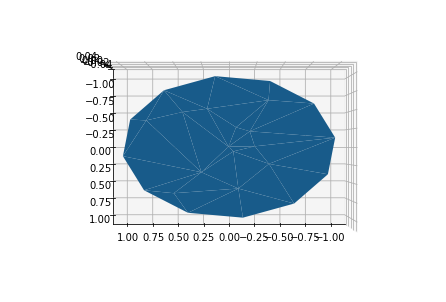

In [ ]:
dot_net = np.array(make_dots_net())
check_dots = dot_net

fig = plt.figure()
ax = Axes3D(fig, azim=90, elev=90)

zero_arr = check_dots
#print(zero_arr)
x = []
y = []
z = []
for i in range(len(check_dots)):
  x.append(check_dots[i][0])
  y.append(check_dots[i][1])
  z.append(0)

# put 0s on the y-axis, and put the y axis on the z-axis
ax.plot_trisurf(x,y,z,shade=True)
plt.show()

In [ ]:
def make_NN_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(2, use_bias=True))
  model.add(layers.Dense(40, activation='tanh'))
  model.add(layers.Dense(50, activation='tanh'))
  model.add(layers.Dense(50, activation='sigmoid'))
  #model.add(layers.Dropout(0.1))
  model.add(layers.Dense(1))
  return model

In [ ]:
u_NN = make_NN_model()
u_NN(dot_net[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.5963919]], dtype=float32)>

In [ ]:
def f(x,y):
  #f = x*x+y*y-5
  f = math.sin(math.pi*(x*x+y*y)) - 4*math.pi*math.cos(math.pi*(x*x+y*y)) + 4*math.pi*math.pi*x*x*math.sin(math.pi*(x*x+y*y)) + 4*math.pi*math.pi*y*y*math.sin(math.pi*(x*x+y*y))
  return f

In [ ]:
#@tf.function
def f_zero(x_,y_):
  x = tf.Variable(x_)
  y = tf.Variable(y_)
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tens = tf.convert_to_tensor([[x,y]])
    u = tf.cast(u_NN(tens), tf.float64)
    u_x = tape.gradient(u,x)
    u_y = tape.gradient(u,y)

  u_xx = tape.gradient(u_x,x)
  u_yy = tape.gradient(u_y,y)

  zEro = u - u_xx - u_yy - f(x_,y_)
  del tape 
  return zEro

In [ ]:
def loss_func(true_vec, pred_vec):
  global dot_net
  f_loss = 0
  u_loss = 0
  for i in range(Dots_Cnt):
    f_loss += abs((f_zero(dot_net[i][0],dot_net[i][1]))**2)
  f_loss = f_loss/Dots_Cnt

  for i in range(Edge_Cnt):
    u_res = u_NN(dot_net[i:i+1])
    #print(u_res)
    u_res = u_res**2
    #print(u_res)
    u_loss += abs(u_res)
  u_loss = tf.cast(u_loss/Edge_Cnt, tf.float64)

  
  if random.randint(0,3) == -1:
    dot_net = np.array(make_dots_net())

  iterloss = f_loss + u_loss

  u_loss_arr = u_loss[0][0].numpy()
  Loss_Arr.append(iterloss)
  #print(Loss_Arr)
  return f_loss + u_loss

In [ ]:
u_NN.compile(
  #optimizer='adam', 
  #optimizer='sgd', 
  optimizer='rmsprop', 
  loss=loss_func, 
  metrics=['accuracy']
)

In [ ]:
zeros_arr = np.zeros(Dots_Cnt)
#u_NN(np.array([[0,0]]))
u_NN.fit(dot_net,zeros_arr,epochs=Epochs_Cnt, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/1000
1/1 - 0s - loss: 12.4479 - accuracy: 0.5200
Epoch 2/1000
1/1 - 0s - loss: 12.0395 - accuracy: 0.5200
Epoch 3/1000
1/1 - 0s - loss: 12.1030 - accuracy: 0.5200
Epoch 4/1000
1/1 - 0s - loss: 11.7548 - accuracy: 0.5200
Epoch 5/1000
1/1 - 0s - loss: 11.9670 - accuracy: 0.5200
Epoch 6/1000
1/1 - 0s - loss: 12.0387 - accuracy: 0.5200
Epoch 7/1000
1/1 - 0s - loss: 12.6929 - accuracy: 0.5200
Epoch 8/1000
1/1 - 0s - loss: 12.8904 - accuracy: 0.5200
Epoch 9/1000
1/1 - 0s - loss: 12.6923 - accuracy: 0.5200
Epoch 10/1000
1/1 - 0s - loss: 12.0318 - accuracy: 0.5200
Epoch 11/1000
1/1 - 0s - loss: 11.8547 - accuracy: 0.5200
Epoch 12/1000
1/1 - 0s - loss: 11.7032 - accuracy: 0.5200
Epoch 13/1000
1/1 - 0s - loss: 12.0765 - accuracy: 0.5200
Epoch 14/1000
1/1 - 0s - loss: 12.0917 - accuracy: 0.5200
Epoch 15/1000
1/1 - 0s - loss: 12.4894 - accuracy: 0.5200
Epoch 16/1000
1/1 - 0s - loss: 12.1481 - accuracy: 0.5200
Epoch 17/1000
1/1 - 0s - loss: 12.2391 - accuracy: 0.5200
Epoch 18/1000
1/1 - 0s 

In [ ]:
argument = math.pi/1
x_arg = -0.0325157  
y_arg = -0.98534307 
#u_NN(np.array([[math.cos(argument),math.sin(argument)]]))
u_NN(np.array([[x_arg,y_arg]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.073894]], dtype=float32)>

In [ ]:
Loss_Temp = []
for i in range(len(Loss_Arr)):
  Loss_Temp.append(Loss_Arr[i][0].numpy()[0])

print(Loss_Temp)

[198.2999107540362, 196.94826375484118, 195.99698546334324, 195.19693869029095, 194.48531583583102, 193.83637096503872, 193.2371047884833, 192.67999372548934, 192.15964847824503, 191.67078063462716, 191.2069593954133, 190.76023529883835, 190.32221526580963, 189.88502168611208, 189.4409005503962, 188.98179224973006, 188.49924684496366, 187.984434925619, 187.42811934410304, 186.82074168504906, 186.1526695615487, 185.41452894610612, 184.59786424190142, 183.69590080137561, 182.70459671243506, 181.62383109452657, 180.45824705623755, 179.21749842912553, 177.91606386867232, 176.57264345885002, 175.2092295452074, 173.84998385894713, 172.51974542948224, 171.24237790478946, 170.03912109939677, 168.92710787829841, 167.91817178836868, 167.01803791922492, 166.22605101044692, 165.53561003221245, 164.9353999147759, 164.41127241954896, 163.9482774854118, 163.53243080729555, 163.15183922285019, 162.7971697292425, 162.4615419011601, 162.14009781786464, 161.8294235584124, 161.527136068533, 161.2315036959

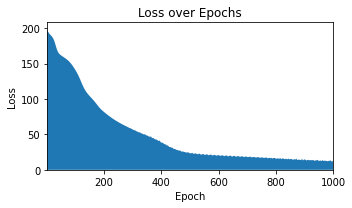

In [ ]:
X_Plot = np.arange(1,1+len(Loss_Temp))
Y_Plot = np.array([Loss_Temp])
# print(Loss_Temp)
# print(X_Plot)
# print(Y_Plot)


fig, ax = plt.subplots(figsize=(5, 3))
ax.stackplot(X_Plot, Y_Plot)
ax.set_title('Loss over Epochs')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xlim(xmin=X_Plot[0], xmax=X_Plot[-1])
fig.tight_layout()
 
plt.show()

U - U_xx - U_yy = F(x,y)
U|x^2+y^2=1 = 0

In [ ]:
def u_real(x,y):
  return x*x+y*y-1

In [ ]:
def make_dots_net_check():
  vec = []
  for i in range(1000):
    vec.append([math.cos(2*math.pi*i/1000), math.sin(2*math.pi*i/1000)])
    # vec.append([0, 0])

  temp_r = np.random.uniform(0, 1, 1000)
  temp_t = np.random.uniform(0, 2*math.pi, 1000)
  for i in range(1000):
    vec.append([temp_r[i]*math.cos(temp_t[i]),temp_r[i]*math.sin(temp_t[i])])
  return vec

In [ ]:
real_dots = make_dots_net_check()
#print(real_dots)
predict = u_NN(np.array(real_dots))
#print(predict)
predict = tf.cast(tf.transpose(predict),tf.float64)

u_true = []
for i in range(len(real_dots)):
  u_true.append(f(real_dots[i][0],real_dots[i][1]))
u_true = np.array([u_true])
u_true = tf.convert_to_tensor(u_true)
print(u_true-predict)

tf.Tensor(
[[ 13.44328321  13.46932066  13.49526805 ...  18.36917217 -13.13636965
   18.23658287]], shape=(1, 2000), dtype=float64)


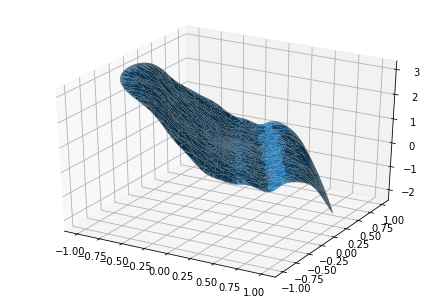

In [ ]:
fig = plt.figure()
# ax = Axes3D(fig, azim=0, elev=90)
ax = Axes3D(fig)

zero_arr = (predict).numpy()[0]
#print(zero_arr)
x = []
y = []
z = []
#for i in range(len(real_dots)):
for i in range(0,2000):
  x.append(real_dots[i][0])
  y.append(real_dots[i][1])
  z.append(zero_arr[i])

# put 0s on the y-axis, and put the y axis on the z-axis
ax.plot_trisurf(x,y,z,shade=True)
plt.show()